In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import glob
pd.options.display.max_rows = 200
pd.options.display.max_columns = 50

GL_DIR = "c:/users/matho/python/baseball/retrosheet/game_logs"

gldf = pd.read_hdf(GL_DIR + "/all_game_logs.h5","game_logs_df")

In [2]:
nec_stats = ['SCORE','HITS','BB','HP','IBB','HR','TB','SB','CS','GDP','PA','SF','SH']
home_stats = [f'HOME_{x}_CT' for x in nec_stats]
away_stats = [f'AWAY_{x}_CT' for x in nec_stats]
df_home_bat = gldf.groupby(['YEAR','HOME_TEAM_ID'])[home_stats].sum().reset_index()
df_home_bat['STAT_TYPE'] = "BAT"
df_home_bat.columns = ['YEAR','TEAM_ID'] + nec_stats + ['STAT_TYPE']
df_home_pit = gldf.groupby(['YEAR','HOME_TEAM_ID'])[away_stats].sum().reset_index()
df_home_pit['STAT_TYPE'] = "PIT"
df_home_pit.columns = ['YEAR','TEAM_ID'] + nec_stats + ['STAT_TYPE']
df_away_bat = gldf.groupby(['YEAR','AWAY_TEAM_ID'])[away_stats].sum().reset_index()
df_away_bat['STAT_TYPE'] = "BAT"
df_away_bat.columns = ['YEAR','TEAM_ID'] + nec_stats + ['STAT_TYPE']
df_away_pit = gldf.groupby(['YEAR','AWAY_TEAM_ID'])[home_stats].sum().reset_index()
df_away_pit['STAT_TYPE'] = "PIT"
df_away_pit.columns = ['YEAR','TEAM_ID'] + nec_stats + ['STAT_TYPE']
tsdf = pd.concat([df_home_bat,df_home_pit,df_away_bat,df_away_pit],axis=0)
lgdf = tsdf.groupby(['YEAR','STAT_TYPE'])[nec_stats].sum()
lgdf = lgdf.xs('BAT',axis=0,level=1)
tsdf = tsdf.groupby(['YEAR','TEAM_ID','STAT_TYPE'])[nec_stats].sum()

In [89]:
lgdf['BASERUNS_A'] = lgdf.HITS + lgdf.BB + lgdf.HP - (0.5*lgdf.IBB) - lgdf.HR
lgdf['BASERUNS_B'] = 1.1*(1.4*lgdf.TB - 0.6*lgdf.HITS - 3*lgdf.HR + 0.1*(lgdf.BB + lgdf.HP - lgdf.IBB) + 0.9*(lgdf.SB - lgdf.CS - lgdf.GDP)) 
lgdf['BASERUNS_C'] = lgdf.PA - lgdf.BB - lgdf.SF - lgdf.SH - lgdf.HP - lgdf.HITS + lgdf.CS + lgdf.GDP
lgdf['BASERUNS_D'] = lgdf.HR
lgdf['BASERUNS'] = (lgdf.BASERUNS_A*lgdf.BASERUNS_B)/(lgdf.BASERUNS_B+lgdf.BASERUNS_C) + lgdf.BASERUNS_D
lgdf['BASERUNS_LG_ADJ'] = lgdf.SCORE / lgdf.BASERUNS

lgdf['RUNS_CREATED'] = ( (lgdf.HITS + lgdf.BB - lgdf.CS - lgdf.HP - lgdf.GDP) * 
                         (lgdf.TB + 0.26*(lgdf.BB - lgdf.IBB + lgdf.HP) + 0.52*(lgdf.SH + lgdf.SF + lgdf.SB) ) / 
                         (lgdf.PA) )

In [90]:
tsdf['BASERUNS_A'] = tsdf.HITS + tsdf.BB + tsdf.HP - (0.5*tsdf.IBB) - tsdf.HR
tsdf['BASERUNS_B'] = 1.1*(1.4*tsdf.TB - 0.6*tsdf.HITS - 3*tsdf.HR + 0.1*(tsdf.BB + tsdf.HP - tsdf.IBB) + 0.9*(tsdf.SB - tsdf.CS - tsdf.GDP)) 
tsdf['BASERUNS_C'] = tsdf.PA - tsdf.BB - tsdf.SF - tsdf.SH - tsdf.HP - tsdf.HITS + tsdf.CS + tsdf.GDP
tsdf['BASERUNS_D'] = tsdf.HR
tsdf['BASERUNS_RAW'] = (tsdf.BASERUNS_A*tsdf.BASERUNS_B)/(tsdf.BASERUNS_B+tsdf.BASERUNS_C) + tsdf.BASERUNS_D
tsdf = tsdf.join(lgdf['BASERUNS_LG_ADJ'])
tsdf['BASERUNS'] = tsdf.BASERUNS_RAW*tsdf.BASERUNS_LG_ADJ

tsdf['RUNS_CREATED'] = ( (tsdf.HITS + tsdf.BB - tsdf.CS + tsdf.HP - tsdf.GDP) * 
                         (tsdf.TB + 0.26*(tsdf.BB - tsdf.IBB + tsdf.HP) + 0.52*(tsdf.SH + tsdf.SF + tsdf.SB) ) / 
                         (tsdf.PA) )

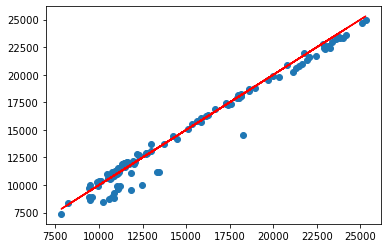

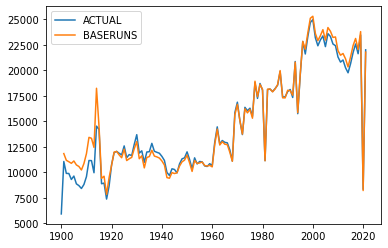

In [91]:
pdf = lgdf.loc[1900:2021].reset_index()
plt.scatter(pdf.BASERUNS,pdf.SCORE)
plt.plot(pdf.BASERUNS,pdf.BASERUNS,'r')
plt.xlabel = "BASERUNS"
plt.ylabel = "ACTUAL"
plt.show()
plt.plot(pdf.YEAR,pdf.SCORE,label="ACTUAL")
plt.plot(pdf.YEAR,pdf.BASERUNS,label="BASERUNS")
plt.xlabel = "YEAR"
plt.ylabel = "RUNS"
plt.legend()
plt.show()

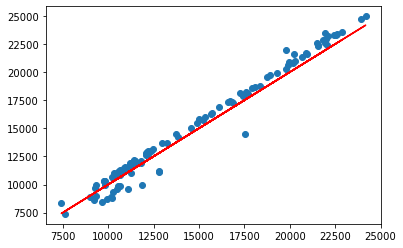

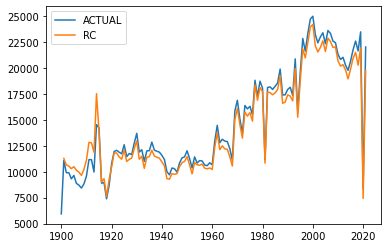

In [92]:
pdf = lgdf.loc[1900:2021].reset_index()
plt.scatter(pdf.RUNS_CREATED,pdf.SCORE)
plt.plot(pdf.RUNS_CREATED,pdf.RUNS_CREATED,'r')
plt.xlabel = "RC"
plt.ylabel = "ACTUAL"
plt.show()
plt.plot(pdf.YEAR,pdf.SCORE,label="ACTUAL")
plt.plot(pdf.YEAR,pdf.RUNS_CREATED,label="RC")
plt.xlabel = "YEAR"
plt.ylabel = "RUNS"
plt.legend()
plt.show()

In [93]:
tsdf['BASERUNS_ERR'] = tsdf.BASERUNS - tsdf.SCORE
tsdf['RUNS_CREATED_ERR'] = tsdf.RUNS_CREATED - tsdf.SCORE
tsdf['BASERUNS_ERR_SQ'] = tsdf.BASERUNS_ERR ** 2
tsdf['RUNS_CREATED_ERR_SQ'] = tsdf.RUNS_CREATED_ERR ** 2
rmse_df = tsdf.groupby(["YEAR","STAT_TYPE"])[['BASERUNS_ERR_SQ','RUNS_CREATED_ERR_SQ']].mean()
rmse_df['BASERUNS_ERR_SQ'] = np.sqrt(rmse_df['BASERUNS_ERR_SQ'])
rmse_df['RUNS_CREATED_ERR_SQ'] = np.sqrt(rmse_df['RUNS_CREATED_ERR_SQ'])

In [111]:
rmse_df.loc[1900:2022][['BASERUNS_ERR_SQ','RUNS_CREATED_ERR_SQ']].mean()

BASERUNS_ERR_SQ        24.804794
RUNS_CREATED_ERR_SQ    38.548603
dtype: float64

In [112]:
import statsmodels.formula.api as sm

In [113]:
formula = "SCORE ~ BASERUNS + RUNS_CREATED"
mdl = sm.ols(formula,tsdf).fit()
mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  SCORE   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                 5.941e+04
Date:                Fri, 04 Feb 2022   Prob (F-statistic):               0.00
Time:                        17:24:02   Log-Likelihood:                -24419.
No. Observations:                5260   AIC:                         4.884e+04
Df Residuals:                    5257   BIC:                         4.886e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -6.1654      2.034     -3.032      0.002     -10.152      -2.179
BASERUNS         0.9737      0.009    110.132      0.000       0.956       0.991
RUNS_CREATED     0.0336      0.008      4.079      0.000       0.017       0.050
==============================================================================
Omnibus:                       59.932   Durbin-Watson:                   1.941
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              103.332
Skew:                           0.018   Prob(JB):                     3.65e-23
Kurtosis:                       3.686   Cond. No.                     5.83e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.83e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""